# An Affine Invariant Multi-CNN Using Reverse Augmentation

## Summary: 
A multi-CNN uses augmentation classifier CNNs to identify types/levels of image augmentation and uses them to reversely augment images before feature classification. 

## Implementation:
1. Affine Augmentation Classifier CNNs:  to identify types/levels of image augmentation (i.e. rotation, scale, shear)
    * Rotation CNN: trained on MNIST rotated @(0, 45, 90 and 135 degrees) - no aliasing of 6/9
    * Scale CNN: trained on MNIST scaled @(100%, 75%, 67%, 50%, 33% and 25%)
    * Shear CNN: trained on MNIST sheared @(0, 15, 30, 45 degrees)
2. Reverse Augmenter: to restore/recover original images by reverse augmenting them with the identified augmentation types/levels in the opposite direction
3. MNIST Classifier CNN: to classify restored images (e.g. digits)

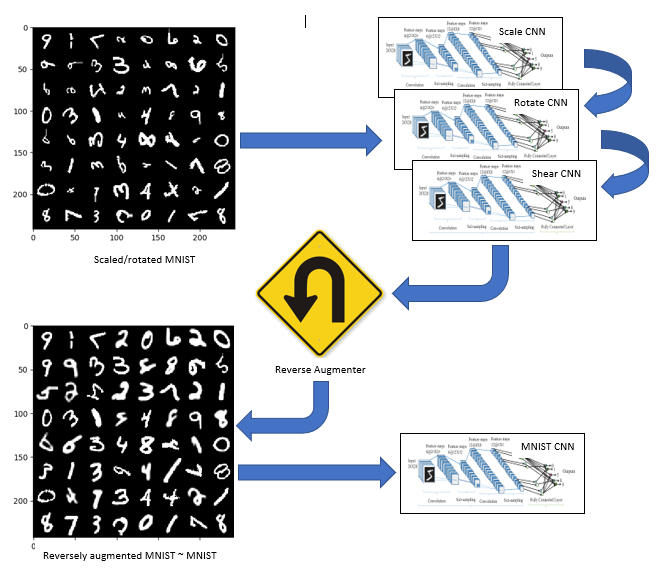

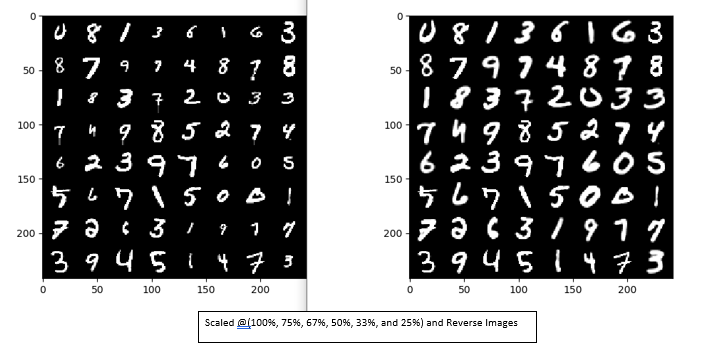

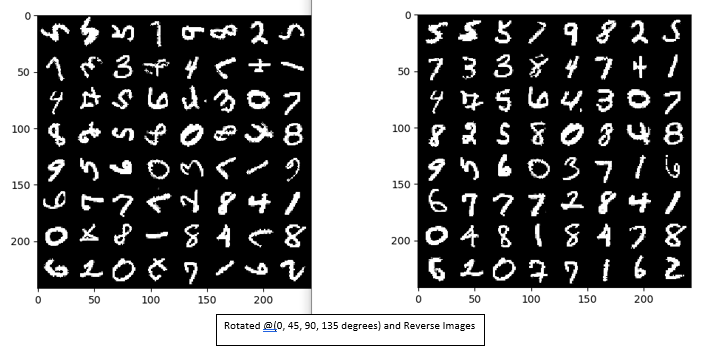

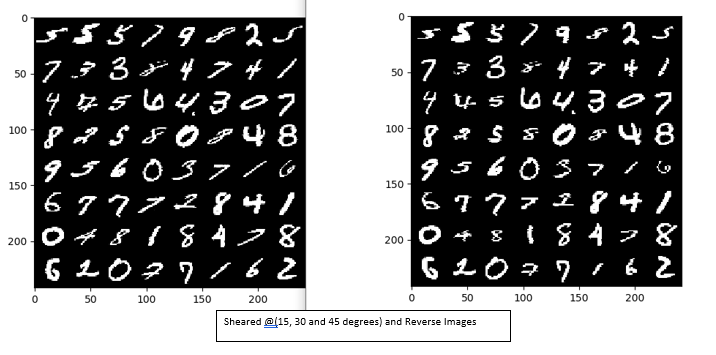

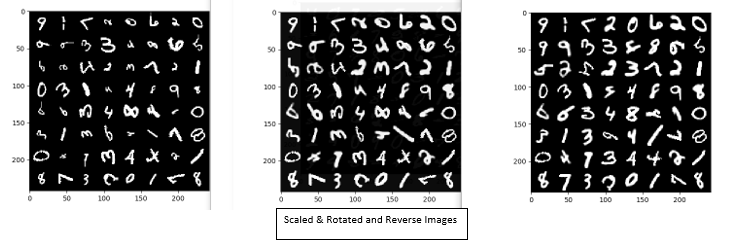




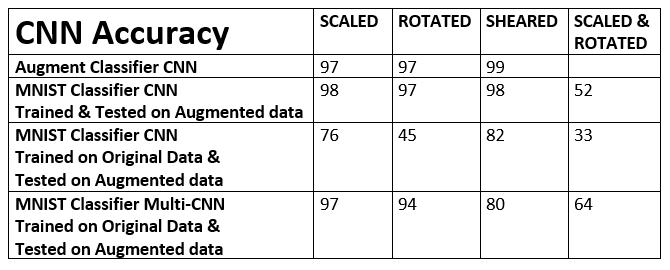

Conclusion:
For scaled or/and rotated images, multi-CNN model is better than transfer learning models (e.g. trained on original iamges and tested on augmented images).  For sheared images, transfer learning model is better due to poor restoration of sheared images.

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.dataset import ConcatDataset as _ConcatDataset
from torch.utils.data.dataset import Subset
from torchvision import transforms, utils
import sys
import numpy as np

import matplotlib as matplotlib
import matplotlib.pyplot as plt

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # if batch_idx == 0:
        #     print("1st batch train targets and images")
        #     print(target)
        #     grid = utils.make_grid(data)
        #     plt.imshow(grid.numpy().transpose((1, 2, 0)))
            # plt.show()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # if batch_idx % args.log_interval == 0:
        #     print(scale)
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()))


def test(args, model_digit, model_scale, model_rotate, device, test_loader, method):
    model_digit.eval()
    model_scale.eval()
    model_rotate.eval()
    test_loss = 0
    correct = 0
    if method != 2:
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                # if test_loss == 0:
                #     print("1st batch Test targets and images")
                #     print(target[0:64])
                #     grid = utils.make_grid(data[0:64])
                #     plt.imshow(grid.numpy().transpose((1, 2, 0)))
                output_digit = model_digit(data)
                test_loss += F.nll_loss(output_digit, target, reduction='sum').item()  # sum up batch loss
                pred_digit = output_digit.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred_digit.eq(target.view_as(pred_digit)).sum().item()
    else:  # method 2
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                if test_loss == 0:
                    print("1st batch Test targets and images")
                    print(target[0:64])
                    plt.figure(0)
                    grid = utils.make_grid(data[0:64])
                    plt.imshow(grid.numpy().transpose((1, 2, 0)))

                output_scale = model_scale(data)
                pred_scale = output_scale.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                for i in range(len(data)):
                    predictme = pred_scale[i][0]
                    if predictme == 1:
                        resize = 28
                    elif predictme == 2:
                        resize = 32
                    elif predictme == 3:
                        resize = 40
                    elif predictme == 4:
                        resize = 56
                    data[i] = data[i] * 0.3081 + 0.1307  # de-normalized
                    data_img = transforms.ToPILImage()(data[i])
                    data[i] = transforms.Compose([
                        transforms.Resize(resize),
                        transforms.CenterCrop(28),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])(data_img)

                plt.figure(1)
                grid = utils.make_grid(data[0:64])
                plt.imshow(grid.numpy().transpose((1, 2, 0)))

                output_rotate = model_rotate(data)
                pred_rotate = output_rotate.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                for i in range(len(data)):
                    predictme = pred_rotate[i][0]
                    revert = -(45 * (predictme - 1))

                    data[i] = data[i] * 0.3081 + 0.1307  # de-normalized
                    data_img = transforms.ToPILImage()(data[i])
                    data[i] = transforms.Compose([
                        transforms.RandomRotation((revert.item(), revert.item())),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])(data_img)

                plt.figure(2)
                grid = utils.make_grid(data[0:64])
                plt.imshow(grid.numpy().transpose((1, 2, 0)))

                # predict digit of reverted images using the model_digit trained on original data
                output_digit = model_digit(data)
                test_loss += F.nll_loss(output_digit, target, reduction='sum').item()  # sum up batch loss
                pred_digit = output_digit.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred_digit.eq(target.view_as(pred_digit)).sum().item()

                plt.show()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def load_train_data(args, kwargs, traintype):
    d0 = datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]))
    d1 = datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]))
    d2 = datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.Resize(24),
                            transforms.Pad(padding=2, padding_mode='edge'),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]))
    d3 = datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.Resize(20),
                            transforms.Pad(padding=4, padding_mode='edge'),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]))
    d4 = datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.Resize(14),
                            transforms.Pad(padding=7, padding_mode='edge'),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]))

    d11 = datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.RandomAffine((45, 45)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]))
    # d12 = datasets.MNIST('../data', train=True, download=True,
    #                     transform=transforms.Compose([
    #                         transforms.RandomAffine((45, 45), scale=(32, 32)),
    #                         transforms.ToTensor(),
    #                         transforms.Normalize((0.1307,), (0.3081,))
    #                     ]))
    # d13 = datasets.MNIST('../data', train=True, download=True,
    #                     transform=transforms.Compose([
    #                         transforms.RandomAffine((45, 45), scale=(20, 20)),
    #                         transforms.Pad(padding=4, padding_mode='edge'),
    #                         transforms.ToTensor(),
    #                         transforms.Normalize((0.1307,), (0.3081,))
    #                     ]))
    # d14 = datasets.MNIST('../data', train=True, download=True,
    #                     transform=transforms.Compose([
    #                         transforms.RandomAffine((45, 45), scale=(14, 14)),
    #                         transforms.ToTensor(),
    #                         transforms.Normalize((0.1307,), (0.3081,))
    #                     ]))

    d21 = datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.RandomAffine((90, 90)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]))
    # d22 = datasets.MNIST('../data', train=True, download=True,
    #                     transform=transforms.Compose([
    #                         transforms.RandomAffine((90, 90), scale=(32, 32)),
    #                         transforms.ToTensor(),
    #                         transforms.Normalize((0.1307,), (0.3081,))
    #                     ]))
    # d23 = datasets.MNIST('../data', train=True, download=True,
    #                     transform=transforms.Compose([
    #                         transforms.RandomAffine((90, 90), scale=(20, 20)),
    #                         transforms.Pad(padding=4, padding_mode='edge'),
    #                         transforms.ToTensor(),
    #                         transforms.Normalize((0.1307,), (0.3081,))
    #                     ]))
    # d24 = datasets.MNIST('../data', train=True, download=True,
    #                     transform=transforms.Compose([
    #                         transforms.RandomAffine((90, 90), scale=(14, 14)),
    #                         transforms.ToTensor(),
    #                         transforms.Normalize((0.1307,), (0.3081,))
    #                     ]))

    d31 = datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.RandomAffine((135, 135)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]))
    # d32 = datasets.MNIST('../data', train=True, download=True,
    #                     transform=transforms.Compose([
    #                         transforms.RandomAffine((135, 135), scale=(32, 32)),
    #                         transforms.ToTensor(),
    #                         transforms.Normalize((0.1307,), (0.3081,))
    #                     ]))
    # d33 = datasets.MNIST('../data', train=True, download=True,
    #                     transform=transforms.Compose([
    #                         transforms.RandomAffine((135, 135), scale=(20, 20)),
    #                         transforms.Pad(padding=4, padding_mode='edge'),
    #                         transforms.ToTensor(),
    #                         transforms.Normalize((0.1307,), (0.3081,))
    #                     ]))
    # d34 = datasets.MNIST('../data', train=True, download=True,
    #                     transform=transforms.Compose([
    #                         transforms.RandomAffine((135, 135), scale=(14, 14)),
    #                         transforms.ToTensor(),
    #                         transforms.Normalize((0.1307,), (0.3081,))
    #                     ]))

    if traintype == 1:
        d1.train_labels[:] = 1  # no augmentation
        d2.train_labels[:] = 2  # 75% scale
        d3.train_labels[:] = 3  # 50% scale
        d4.train_labels[:] = 4  # 25% scale

        for i in range(list(d11.train_labels.size())[0]):
            if d11.train_labels[i] == 0:
                d11.train_labels[i] = 1  # rotating 45 degrees & 100% scale
            else:
                d11.train_labels[i] = 2  # 11 (because MNIST labels can't bigger than 9)
        # # for i in range(list(d12.train_labels.size())[0]):
        #     if d12.train_labels[i] == 0:
        #         d12.train_labels[i] = 2  # rotating 45 degrees & 75% scale
        #     else:
        #         d12.train_labels[i] = 12
        # # for i in range(list(d13.train_labels.size())[0]):
        #     if d13.train_labels[i] == 0:
        #         d13.train_labels[i] = 3  # rotating 45 degrees & 50% scale
        #     else:
        #         d13.train_labels[i] = 13
        # # for i in range(list(d14.train_labels.size())[0]):
        #     if d14.train_labels[i] == 0:
        #         d14.train_labels[i] = 4  # rotating 45 degrees & 25% scale
        #     else:
        #         d14.train_labels[i] = 14

        # for i in range(list(d21.train_labels.size())[0]):
            if d21.train_labels[i] == 0:
                d21.train_labels[i] = 1  # rotating 90 degrees & 100% scale
            else:
                d21.train_labels[i] = 3  # 21
        # # for i in range(list(d22.train_labels.size())[0]):
        #     if d22.train_labels[i] == 0:
        #         d22.train_labels[i] = 2  # rotating 90 degrees & 75% scale
        #     else:
        #         d22.train_labels[i] = 22
        # # for i in range(list(d23.train_labels.size())[0]):
        #     if d23.train_labels[i] == 0:
        #         d23.train_labels[i] = 3  # rotating 90 degrees & 50% scale
        #     else:
        #         d23.train_labels[i] = 23
        # # for i in range(list(d24.train_labels.size())[0]):
        #     if d24.train_labels[i] == 0:
        #         d24.train_labels[i] = 4  # rotating 90 degrees & 25% scale
        #     else:
        #         d24.train_labels[i] = 24

        # for i in range(list(d31.train_labels.size())[0]):
            if d31.train_labels[i] == 0:
                d31.train_labels[i] = 1  # rotating 135 degrees & 100% scale
            else:
                d31.train_labels[i] = 4  # 31
        # # for i in range(list(d32.train_labels.size())[0]):
        #     if d32.train_labels[i] == 0:
        #         d32.train_labels[i] = 2  # rotating 135 degrees & 75% scale
        #     else:
        #         d32.train_labels[i] = 32
        # # for i in range(list(d33.train_labels.size())[0]):
        #     if d33.train_labels[i] == 0:
        #         d33.train_labels[i] = 3  # rotating 135 degrees & 50% scale
        #     else:
        #         d33.train_labels[i] = 33
        # # for i in range(list(d34.train_labels.size())[0]):
        #     if d34.train_labels[i] == 0:
        #         d34.train_labels[i] = 4  # rotating 135 degrees & 25% scale
        #     else:
        #         d34.train_labels[i] = 34

    Scale_data = _ConcatDataset([d1, d2, d3, d4])  # no rotation
    Rotate_data = _ConcatDataset([d1, d11, d21, d31])  # no scale
    train_loaderO = torch.utils.data.DataLoader(
        d0, batch_size=args.batch_size, shuffle=True, **kwargs)
    train_loaderS = torch.utils.data.DataLoader(
        Scale_data, batch_size=args.batch_size, shuffle=True, **kwargs)
    train_loaderR = torch.utils.data.DataLoader(
        Rotate_data, batch_size=args.batch_size, shuffle=True, **kwargs)
    return train_loaderO, train_loaderS, train_loaderR


def load_test_data(args, kwargs):
    t1 = datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]))
    t2 = datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.Resize(24),
                            transforms.Pad(padding=2, padding_mode='edge'),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]))
    t3 = datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.Resize(20),
                            transforms.Pad(padding=4, padding_mode='edge'),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]))
    t4 = datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.Resize(14),
                            transforms.Pad(padding=7, padding_mode='edge'),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ]))

    t11 = datasets.MNIST('../data', train=True, download=True,
                         transform=transforms.Compose([
                             transforms.RandomRotation((45, 45)),
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))
                         ]))
    t12 = datasets.MNIST('../data', train=True, download=True,
                         transform=transforms.Compose([
                             transforms.RandomRotation((45, 45)),
                             transforms.Resize(24),
                             transforms.Pad(padding=2, padding_mode='edge'),
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))
                         ]))
    t13 = datasets.MNIST('../data', train=True, download=True,
                         transform=transforms.Compose([
                             transforms.RandomRotation((45, 45)),
                             transforms.Resize(20),
                             transforms.Pad(padding=4, padding_mode='edge'),
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))
                         ]))
    t14 = datasets.MNIST('../data', train=True, download=True,
                         transform=transforms.Compose([
                             transforms.RandomRotation((45, 45)),
                             transforms.Resize(14),
                             transforms.Pad(padding=7, padding_mode='edge'),
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))
                         ]))

    t21 = datasets.MNIST('../data', train=True, download=True,
                         transform=transforms.Compose([
                             transforms.RandomRotation((90, 90)),
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))
                         ]))
    t22 = datasets.MNIST('../data', train=True, download=True,
                         transform=transforms.Compose([
                             transforms.RandomRotation((90, 90)),
                             transforms.Resize(24),
                             transforms.Pad(padding=2, padding_mode='edge'),
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))
                         ]))
    t23 = datasets.MNIST('../data', train=True, download=True,
                         transform=transforms.Compose([
                             transforms.RandomRotation((90, 90)),
                             transforms.Resize(20),
                             transforms.Pad(padding=4, padding_mode='edge'),
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))
                         ]))
    t24 = datasets.MNIST('../data', train=True, download=True,
                         transform=transforms.Compose([
                             transforms.RandomRotation((90, 90)),
                             transforms.Resize(14),
                             transforms.Pad(padding=7, padding_mode='edge'),
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))
                         ]))

    t31 = datasets.MNIST('../data', train=True, download=True,
                         transform=transforms.Compose([
                             transforms.RandomRotation((135, 135)),
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))
                         ]))
    t32 = datasets.MNIST('../data', train=True, download=True,
                         transform=transforms.Compose([
                             transforms.RandomRotation((135, 135)),
                             transforms.Resize(24),
                             transforms.Pad(padding=2, padding_mode='edge'),
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))
                         ]))
    t33 = datasets.MNIST('../data', train=True, download=True,
                         transform=transforms.Compose([
                             transforms.RandomRotation((135, 135)),
                             transforms.Resize(20),
                             transforms.Pad(padding=4, padding_mode='edge'),
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))
                         ]))
    t34 = datasets.MNIST('../data', train=True, download=True,
                         transform=transforms.Compose([
                             transforms.RandomRotation((135, 135)),
                             transforms.Resize(14),
                             transforms.Pad(padding=7, padding_mode='edge'),
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))
                         ]))

    comb_test = _ConcatDataset([t1, t2, t3, t4, t11, t12, t13, t14, t21, t22, t23, t24, t31, t32, t33, t34])
    test_loaderA = torch.utils.data.DataLoader(
        comb_test, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader1 = torch.utils.data.DataLoader(
        t1, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader2 = torch.utils.data.DataLoader(
        t2, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader3 = torch.utils.data.DataLoader(
        t3, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader4 = torch.utils.data.DataLoader(
        t4, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader11 = torch.utils.data.DataLoader(
        t1, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader12 = torch.utils.data.DataLoader(
        t2, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader13 = torch.utils.data.DataLoader(
        t3, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader14 = torch.utils.data.DataLoader(
        t4, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader21 = torch.utils.data.DataLoader(
        t1, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader22 = torch.utils.data.DataLoader(
        t2, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader23 = torch.utils.data.DataLoader(
        t3, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader24 = torch.utils.data.DataLoader(
        t4, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader31 = torch.utils.data.DataLoader(
        t1, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader32 = torch.utils.data.DataLoader(
        t2, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader33 = torch.utils.data.DataLoader(
        t3, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader34 = torch.utils.data.DataLoader(
        t4, batch_size=args.test_batch_size, shuffle=True, **kwargs)

    # return test_loaderA, test_loader1, test_loader2, test_loader3, test_loader4, \
    #                      test_loader11, test_loader12, test_loader13, test_loader14, \
    #                      test_loader21, test_loader22, test_loader23, test_loader24, \
    #                      test_loader31, test_loader32, test_loader33, test_loader34
    return test_loaderA


def runit(args, device, train_loader_digit, train_loader_scale, train_loader_rotate, test_loaderA, method):
    model_digit = Net().to(device)
    model_scale = Net().to(device)
    model_rotate = Net().to(device)
    # print(model_digit)
    optimizer_digit = optim.SGD(model_digit.parameters(), lr=args.lr, momentum=args.momentum)
    optimizer_scale = optim.SGD(model_scale.parameters(), lr=args.lr, momentum=args.momentum)
    optimizer_rotate = optim.SGD(model_rotate.parameters(), lr=args.lr, momentum=args.momentum)

    for epoch in range(1, args.epochs + 1):
        if method == 2:
            print("Training model_scale ...")
            train(args, model_scale, device, train_loader_scale, optimizer_scale, epoch)
            print("Training model_rotate ...")
            train(args, model_rotate, device, train_loader_rotate, optimizer_rotate, epoch)
        print("Training model_digit ...")
        train(args, model_digit, device, train_loader_digit, optimizer_digit, epoch)
        print("Testing: All Affine")
        test(args, model_digit, model_scale, model_rotate, device, test_loaderA, method)

    if (args.save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=1, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')

    args = parser.parse_args(args=[])
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    torch.manual_seed(args.seed)
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    (train_loaderO, train_loaderS, train_loaderR) = load_train_data(args, kwargs, 1)
    (test_loaderA) = load_test_data(args, kwargs)

    # print("METHOD 0: TRAIN & TEST ON rotateD DATA")
    # runit(args, device, train_loaderA, train_loaderA, test_loaderA, test_loader1, test_loader2, test_loader3,
    #       test_loader4, 0)

    # print("METHOD 1: TRAIN ON ORIGINAL DATA & TEST ON AFFINE DATA")
    # runit(args, device, train_loaderO, train_loaderO, train_loaderO, test_loaderA, 0)

    print("METHOD 2: TRAIN TO IDENTIFY AFFINE & REVERT to ORIGINAL IMAGES & TEST ON REVERTED DATA")
    runit(args, device, train_loaderO, train_loaderS, train_loaderR, test_loaderA, 2)


if __name__ == '__main__':
    main()
